# multi-class change detection using image segmentation deep learning models

> * 🔬 Data Science
> * 🥠 Deep Learning and image segmentation

## Table of Contents

* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Export training data](#Export-training-data)
* [Prepare the data](#Prepare-the-data)
* [Train change detection model](#Train-change-detection-model)
  * [Load UNet model architecture](#Load-UNet-model-architecture)
  * [Tune for optimal learning rate](#Tune-for-optimal-learning-rate)
  * [Fit the model](#Fit-the-model)
  * [Visualize results](#Visualize-results)
  * [Save the model](#Save-the-model)
* [Model inferencing](#Model-inferencing)
  * [Generate a change raster utilizing the Classify Pixels Using Deep Learning tool](#Generate-a-change-raster-utilizing-the-Classify-Pixels-Using-Deep-Learning-tool)
  * [Visualize change map](#Visualize-change-map)
* [Conclusion](#Conclusion)
* [References](#References)

# Introduction

Change detection is a process used in global remote sensing to find changes in landcover over a period of time, either by natural or man-made activities, over large areas. This process is used in many applications, including in environmental monitoring, disaster evaluation, and urban expansion studies. Current change detection methods typically follow one of two approaches, utilizing either post-classification analysis or difference image analysis. These methods are often resource-heavy and time intensive.

In this notebook, we will show a novel way to detect and classify change using semantic segmentation models available in `arcgis.learn`. For more details about the image segmentation model and its workings, refer to [How U-net works?](https://developers.arcgis.com/python/guide/how-unet-works/) in the guide section.

## Necessary imports

In [1]:
import os, zipfile
from pathlib import Path
from os import listdir
from os.path import isfile, join

from arcgis import GIS
from arcgis.learn import prepare_data, UnetClassifier

## Connect to your GIS

In [6]:
gis = GIS("home")
ent_gis = GIS(profile='your_enterprise_profile')

## Export training data

For this scenario, we have landsat-7 imagery and a classified change map with class information between two time periods (2001-2016) collected over Egypt, with a spatial resolution of 30 m. We will export this data in the “Classified Tiles” metadata format available in the `Export Training Data For Deep Learning` tool. The tool is available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) and [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server).

For the model to identify changes between imagery, we will build composite imagery from two different time periods using the [composite](https://pro.arcgis.com/en/pro-app/latest/tool-reference/data-management/composite-bands.htm) tool in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview). It will be provided as an `Input Raster` to the model, and the change map will be provided as labels. The change map was produced by providing the `change detection wizard` available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview), with land use and land cover classification maps from two time periods (2011, 2016) or the from and to raster. The 'to class' or the class to which it has changed to, is used as change labels for the model training. The `change detection wizard` tool was used in order to create a change dataset. If change raster is already avialable it can be used directly to export and train the model.

- `Input Raster`: Composite_imagery_2001_2016
- `Input feature class or classified raster`: change_map_2001_2016
- `Tile Size X & Tile Size Y`: 256
- `Stride X & Stride Y`: 128
- `Meta Data Format`: 'Classified Tiles' as we are training a segmentation model.
- `Environments`: Set optimum `Cell Size`, `Processing Extent`.

The rasters used for exporting the training dataset are provided below:

In [5]:
landsat_composite_2001_16 = ent_gis.content.get('dbe2221e4e1240e986586f0eb3a1479b')
landsat_composite_2001_16

<Item title:"train_area_landsat_composite_2001_16" type:Imagery Layer owner:api_data_owner>

In [6]:
landsat_changemap_2001_16 = ent_gis.content.get('8eef999714d64e9f9494030b9c5f76c2')
landsat_changemap_2001_16

<Item title:"train_area_changemap_tif" type:Imagery Layer owner:api_data_owner>

<div style="align: center; text-align:center; line-height: 5em">
    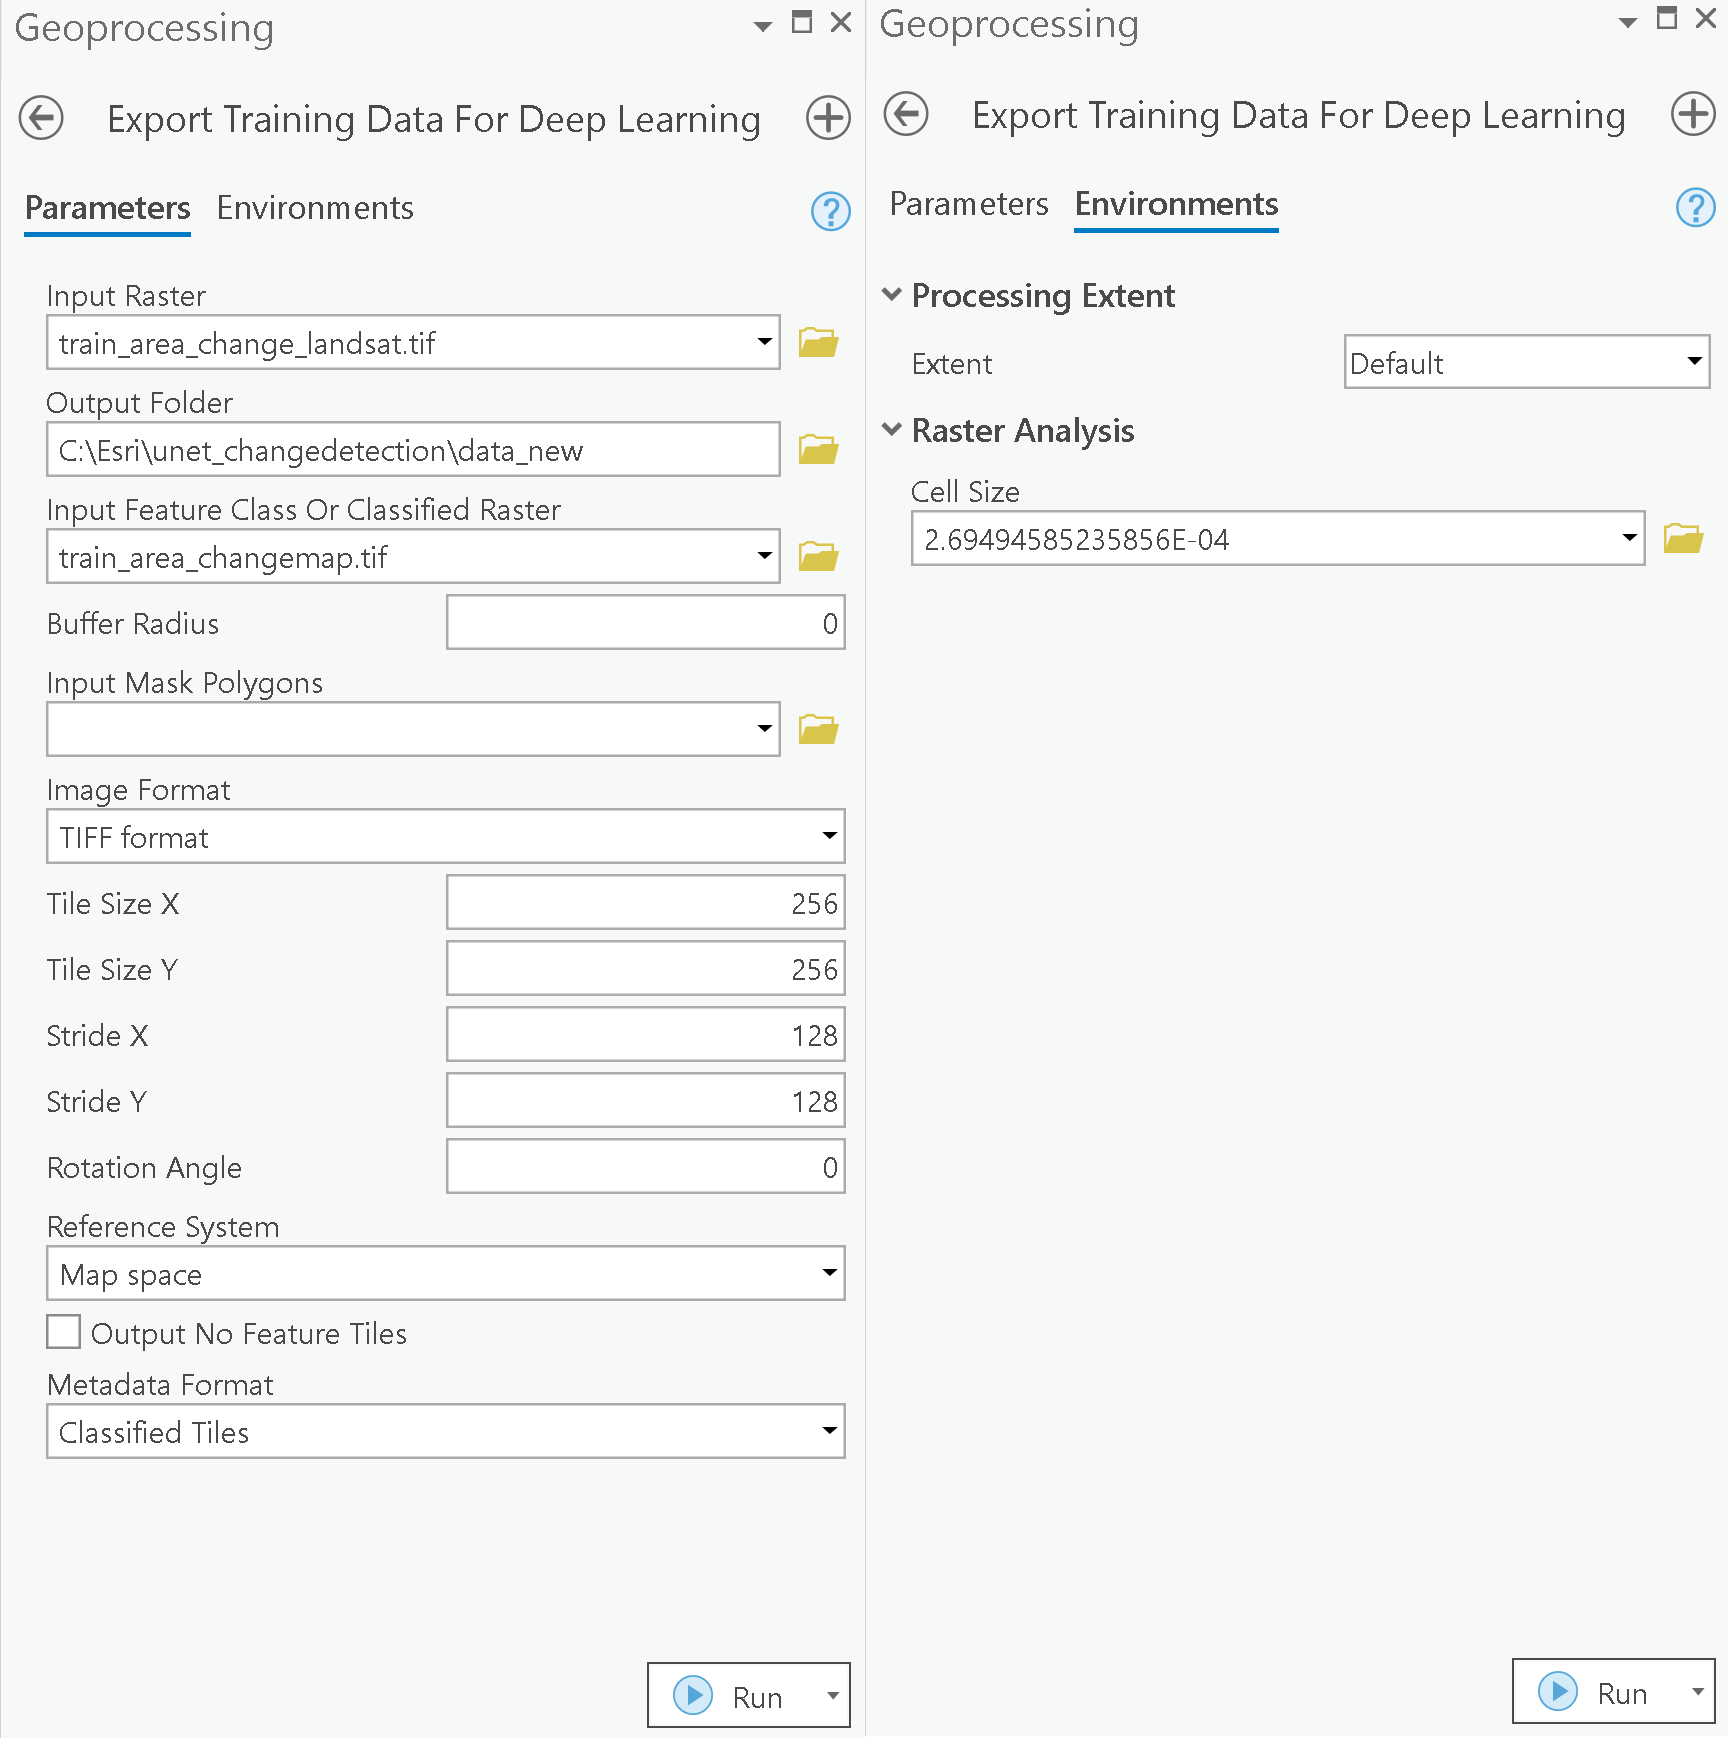 
    <div class="caption"> Export Training Data for Deep Learning tool</div>
</div>

## Prepare the data

Alternatively, we have also provided a subset of training data containing a few samples with the rasters used for exporting the training dataset. You may use the data directly to carry out the experiments.

<Item title:"multi_class_change_detection_using_segmentation_deep_learning_models" type:Image Collection owner:api_data_owner>
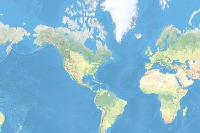

In [7]:
training_data = gis.content.get('ad6e6618a6704e9fa213ee2dc40bbe76')
training_data

In [8]:
filepath = training_data.download(file_name=training_data.name)

In [9]:
#Extract the data from the zipped image collection
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [11]:
output_path = Path(os.path.join(os.path.splitext(filepath)[0]))

In [12]:
data=prepare_data(output_path,
                  batch_size=2, 
                  class_mapping={1:'to forest',2:'to savannas',3:'to grasslands',4:'to wetlands',5:'to croplands',
                                 6:'to urban',7:'to tundra',8:'to barren',9:'to water',10:'to open shrublands',
                                 11:'No change'})

Displayed below are the various change class values with names with which pixels of the change raster are assigned 

In [13]:
data.class_mapping

{1: 'to forest',
 2: 'to savannas',
 3: 'to grasslands',
 4: 'to wetlands',
 5: 'to croplands',
 6: 'to urban',
 7: 'to tundra',
 8: 'to barren',
 9: 'to water',
 10: 'to open shrublands',
 11: 'No change'}

### Visualize a few samples from your training data

To get a better sense of the training data, we will use the `show_batch()` method in `arcgis.learn`. This method randomly picks a few training chips, overlayed by their respective labels, and visualizes them.

- `alpha`: Opacity of overlayed labels over the training chips

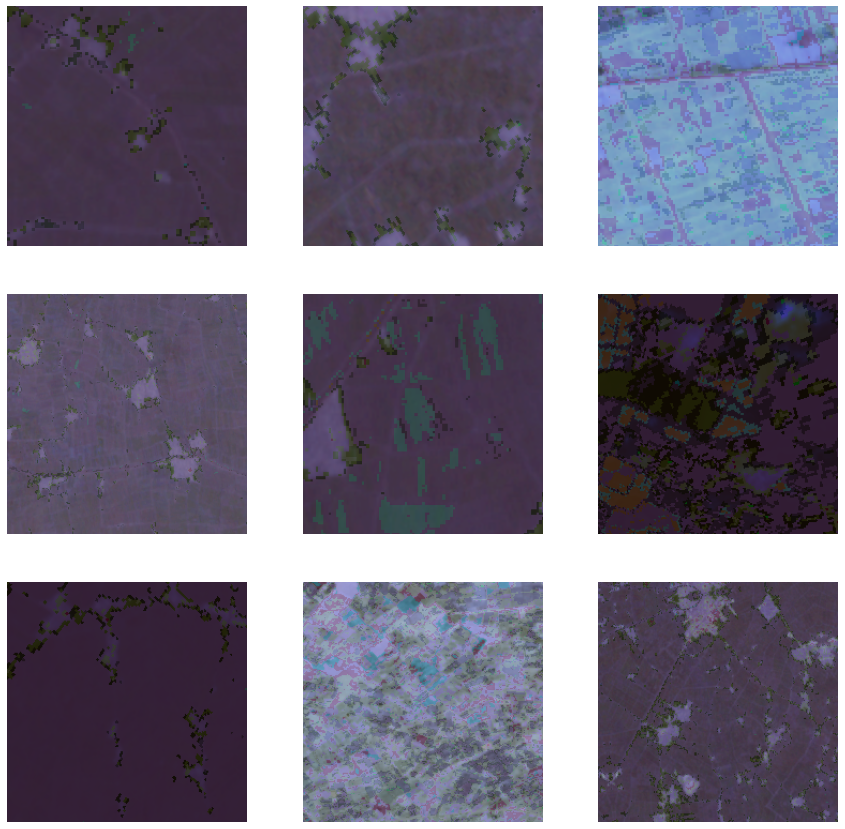

In [9]:
data.show_batch(alpha=0.5)

## Train change detection model

### Load UNet model architecture

In [4]:
model = UnetClassifier(data)

#or

#model = PSPNetClassifier(data)

#or

#model = DeepLab(data)

### Tune for optimal learning rate

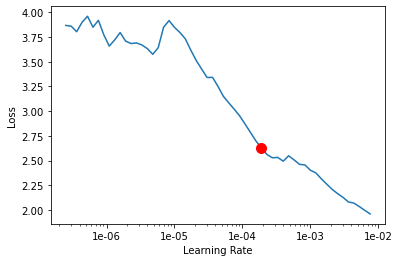

In [5]:
lr = model.lr_find()

### Fit the model

To train the model, we use the `fit()` method. To start, we will train our model for 10 epochs. The number of epochs defines how many times a model will be exposed to the entire training set.

- `epochs`: Number of cycles of training on the data.
- `lr`: Learning rate to be used for training the model.

In [6]:
model.fit(10, lr)

Here, with 10 epochs, we see that both the training and validation losses have decreased significantly, indicating that the model is learning to detect changes.

### Visualize results

It is a good practice to visualize the results obtained from the model with the actual ground truth data. The `show_results` function picks random samples, and visualizes the ground truth and model predictions side by side. This enables us to preview the results of the model within the notebook.

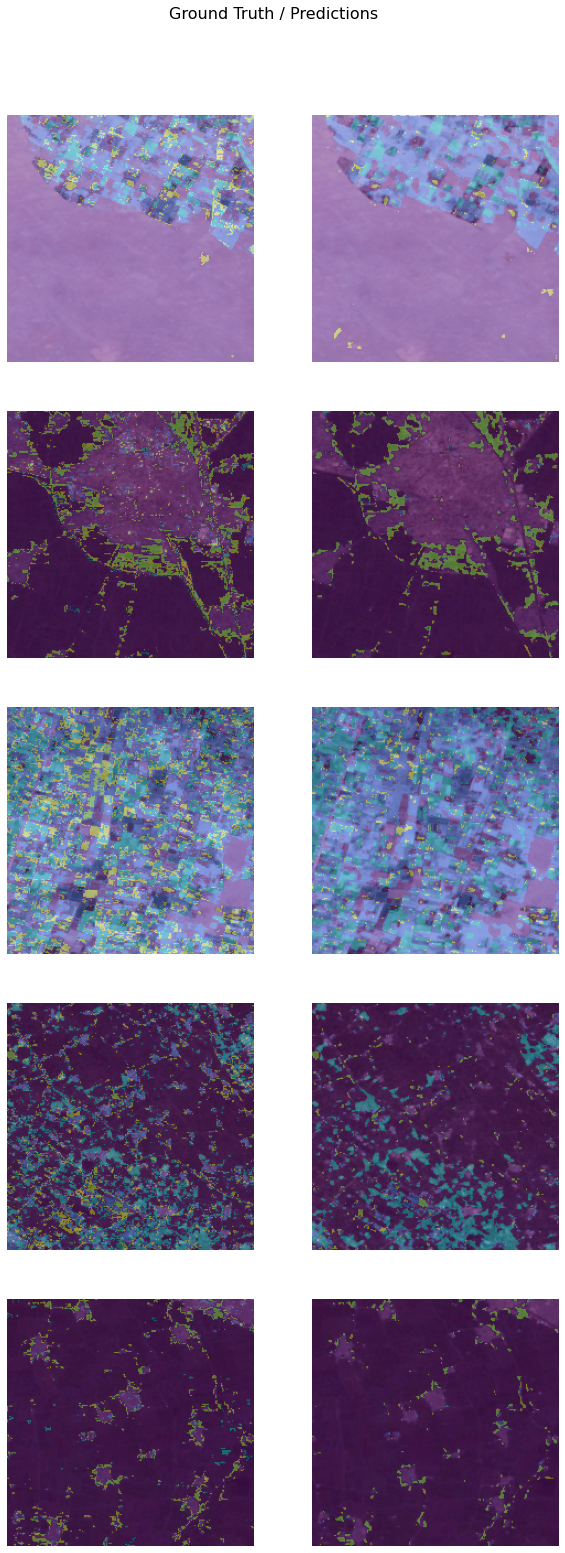

In [7]:
model.show_results()

### Save the model

We will save the model that we trained as a 'Deep Learning Package' ('.dlpk' format). A Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the trained model. By default, it will be saved to a sub-folder inside the training data folder with the name "models".

In [ ]:
model.save(r'unet_change_model_e10')

### Compute model metrics

In [19]:
model.accuracy()

0.8944873809814453

## Model inferencing

### Generate a change raster utilizing the Classify Pixels Using Deep Learning tool

After training the change detection model and saving the weights for detecting changes, we can use the `Classify Pixels Using Deep Learning` tool, available in both [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) and [ArcGIS Enterprise](https://www.esri.com/en-us/arcgis/products/arcgis-enterprise/overview), for inferencing at scale. The test raster is a composite of 2001 and 2016 rasters, for another geographically identical location.

In [29]:
test_data = ent_gis.content.get('8e0ca6e7cefb45289eccc0e7ae2c9bfd')
test_data

<Item title:"test_area_change_landsat_tif" type:Imagery Layer owner:api_data_owner>

<div style="align: left; text-align:center; line-height: 5em">
    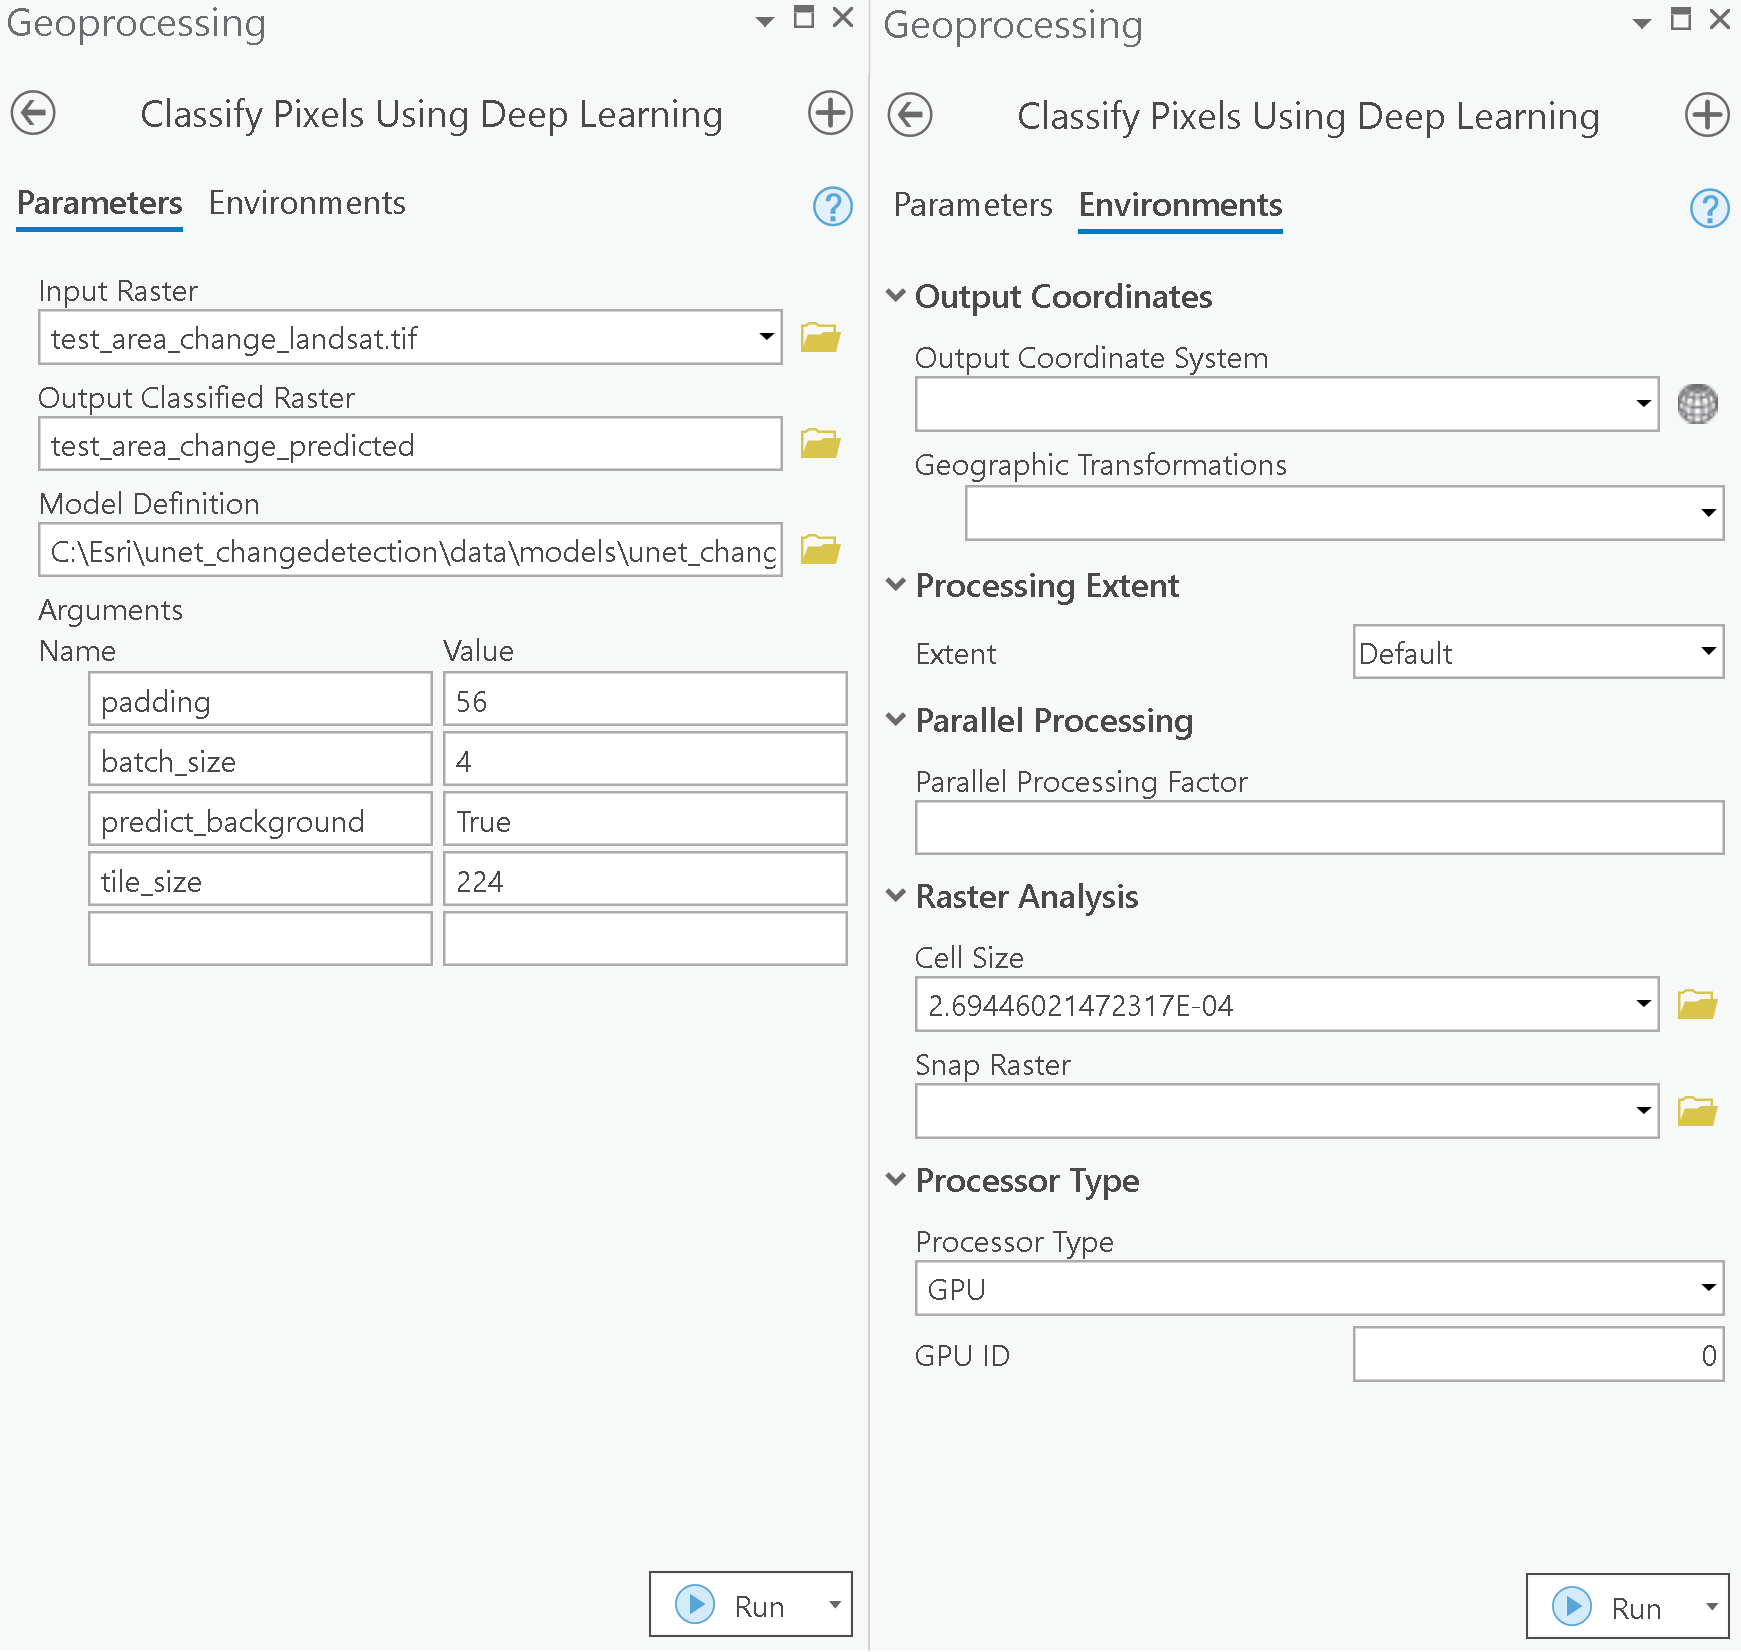
    <div class="caption">Classify Pixels Using Deep Learning tool</div>
</div>

`with arcpy.EnvManager(cellSize=0.0002694460214, processorType='GPU', gpuId = '0'):`


    `out_classified_raster = arcpy.ia.ClassifyPixelsUsingDeepLearning("test_area_change_landsat.tif", r"C:\Esri\unet_multiclass_change\models\model.emd", "padding 56;batch_size 4;predict_background True;tile_size 224")`

    `out_classified_raster.save(r"C:\Esri\unet_multiclass_change\test_area_change_predicted.tif")`

### Visualize change map

The image below displays the final test areas used for model predictions for 2011 and 2016, as well as the final predicted areas of change from 2011 to 2016.

<div style="align: left; text-align:center;line-height: 5em">
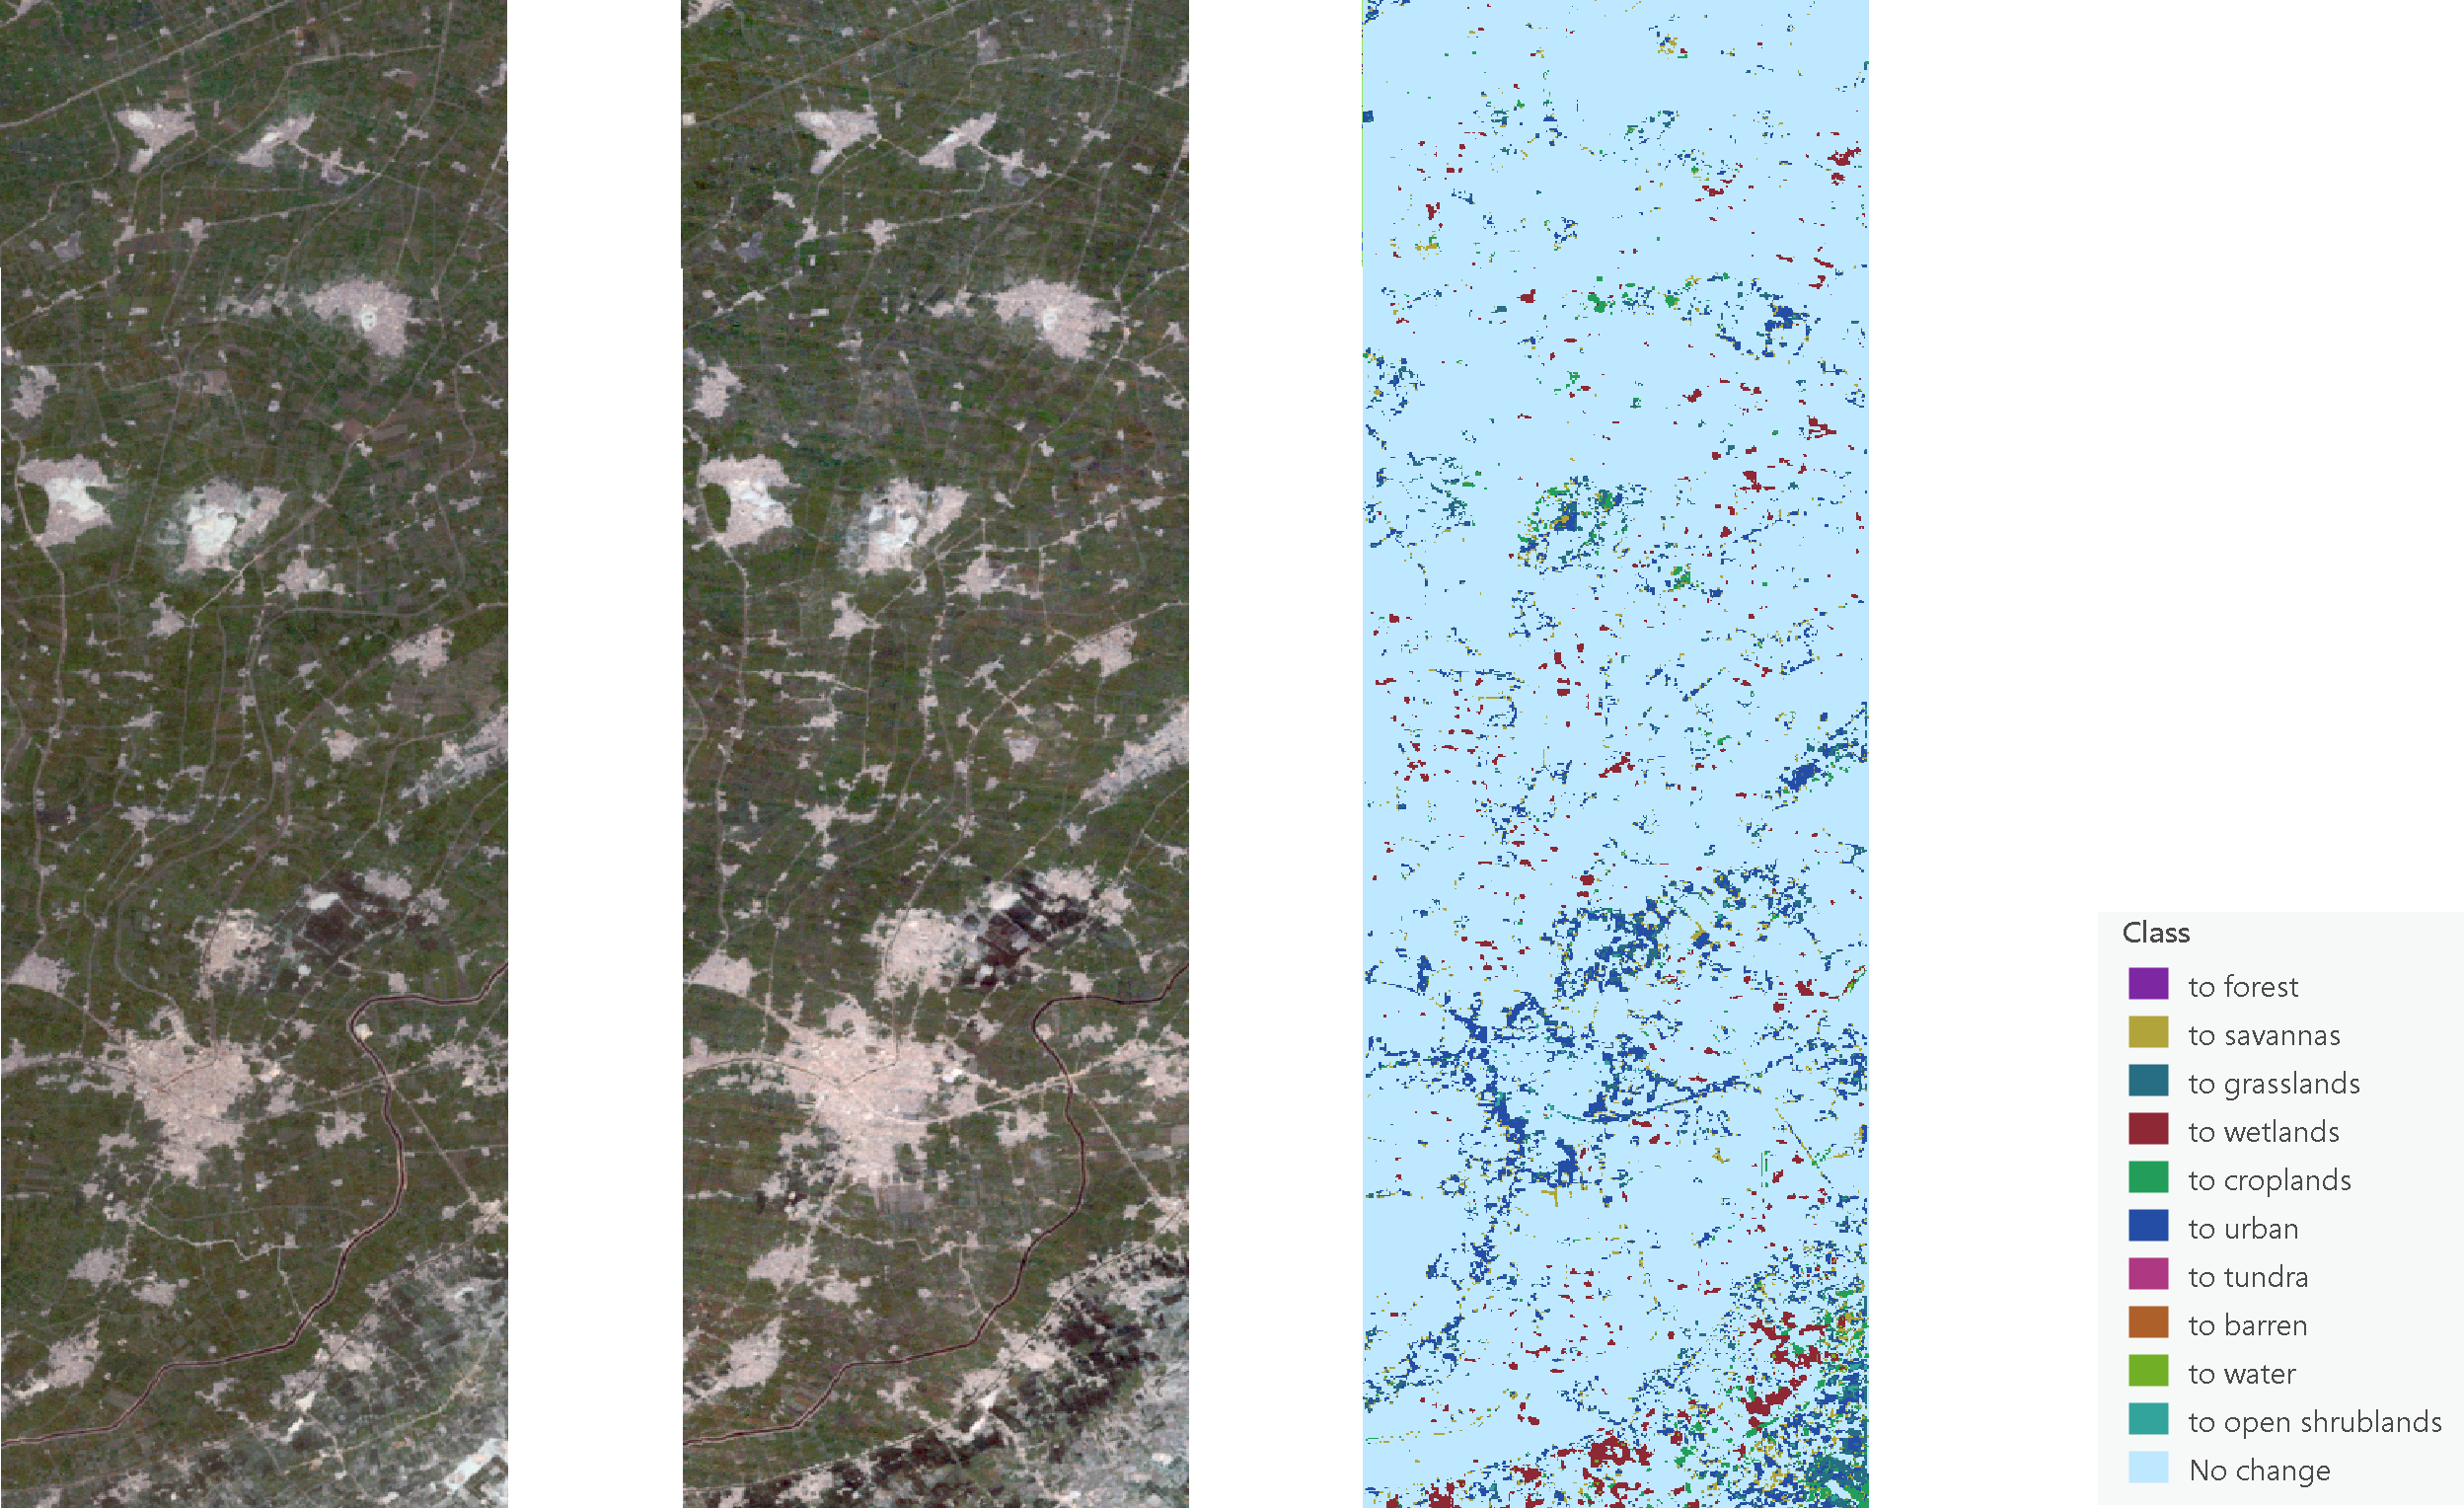
<div class="caption"> (Left) 2011, (Mid) 2016, and (Right) predicted change from 2011 to 2016 </div>
</div>

## Conclusion

In this notebook, we demonstrated how to use image segmentation models, i.e. U-Net, DeepLab, PSPNet, available in `arcgis.learn`, to detect multi-class changes between imagery of two time-periods.

## References

[1] Olaf Ronneberger, Philipp Fischer, Thomas Brox: U-Net: Convolutional Networks for Biomedical Image Segmentation, 2015;[arXiv:1505.04597](https://arxiv.org/abs/1505.04597) 